# Anomalieerkennung in Zeitreihen

### Quellen

Ausgangspunkt für dieses Notebook war das Tutorial "Timeseries anomaly detection using an Autoencoder" auf [kreas.io](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)

Dieses Notebook verwendet ein Reconstruction Convolutional Autoencoder-Modell zur Anomalieerkennung in einer univariaten Zeitreihe aus dem [NAB](https://github.com/numenta/NAB)-Projekt.

In [24]:
# Falls Tensorflow nicht mit GPU genutzt werden kann sind die folgenden Parameter zu setzen

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


In [26]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

## Daten Laden

Die Daten wurden zuvor von GitHub geladen und liegen als `csv` Datei vor.

In [27]:
file_path = "datasets/univariate_machine_temp/machine_temperature_system_failure.csv"

temp_time_data = pd.read_csv(file_path, parse_dates=True, index_col="timestamp")


Kurze Prüfung der Datenstruktur

In [28]:

print(temp_time_data.head())


                         value
timestamp                     
2013-12-02 21:15:00  73.967322
2013-12-02 21:20:00  74.935882
2013-12-02 21:25:00  76.124162
2013-12-02 21:30:00  78.140707
2013-12-02 21:35:00  79.329836


Einige statistische Informationen zur Verteilungung der Daten

In [29]:
print(temp_time_data.describe())

              value
count  22695.000000
mean      85.926498
std       13.746912
min        2.084721
25%       83.080078
50%       89.408246
75%       94.016252
max      108.510543


Visualisierung der Daten

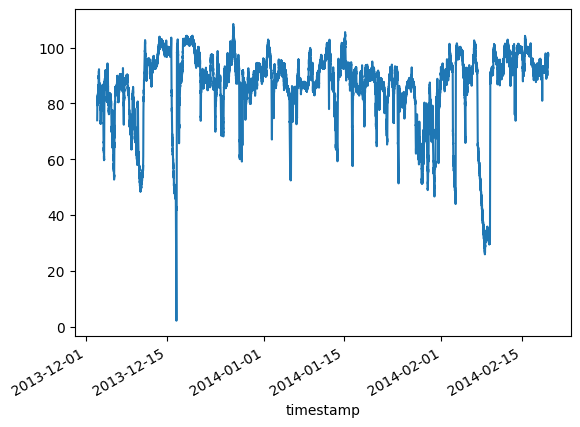

In [30]:
fig, ax = plt.subplots()
temp_time_data.plot(legend=False, ax=ax)
plt.show()

## Vorbereitung der Daten

Für das Training werden die ersten beiden Wochen der Zeitreihe verwendet.


In [31]:
start_time = pd.to_datetime('2013-12-02 00:00:00')
end_time = pd.to_datetime('2013-12-15 00:00:00')

temp_time_data_training = temp_time_data[(temp_time_data.index >= start_time) & 
                          (temp_time_data.index <= end_time)]

Hier visualisieren wir nochmals den Trainingsteil des Datensatzes.

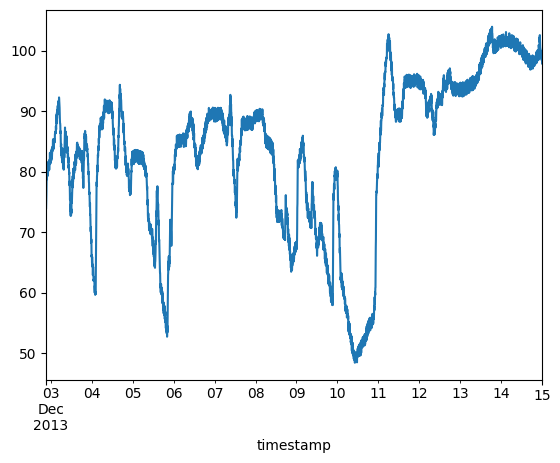

In [32]:
fig, ax = plt.subplots()
temp_time_data_training.plot(legend=False, ax=ax)
plt.show()

Bei der univariaten Analyse muss das Modell in die Lage versetzt werden, Entwicklungen in der Abfolge der Daten erkennen zu können. Daher erhält das Modell in jedem Schritt nicht nur einzelne Werte sondern jeweils Sequenzen von Einzelwerten als Input.

Die Zeitstempel sind in 5-Minuten-Intervallen erfasst, daher wird jeweils eine Sequenz von 288 Werten  betrachtet, was einem Tag entspricht (60 * 24 / 5 = 288).

In [33]:
training_mean = temp_time_data_training.mean()
training_std = temp_time_data_training.std()
df_training_value = (temp_time_data_training - training_mean) / training_std
print("Anzahl an Training Samples:", len(df_training_value))

TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


training_data = create_sequences(df_training_value.values)
print("Training input shape: ", training_data.shape)

Anzahl an Training Samples: 3490
Training input shape:  (3203, 288, 1)


## Definition des Modells

Hier wird ein Convolutional Reconstruction Autoencoder-Modell definiert. Mit Input der Form `(batch_size, sequence_length, num_features)` und gleichförmigem Output.

In [34]:

model = keras.Sequential(
    [
        layers.Input(shape=(training_data.shape[1], training_data.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 288, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

## Training

Der Trainingsinput ist hier gleichzeitig der Output, da es sich ja um ein Reconstruction Modell handelt.

In [35]:

history = model.fit(
    training_data,
    training_data,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4807 - val_loss: 1.3883
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1149 - val_loss: 0.0510
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0385 - val_loss: 0.0239
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0297 - val_loss: 0.0304
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0257 - val_loss: 0.0220
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0221 - val_loss: 0.0197
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0199 - val_loss: 0.0185
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180 - val_loss: 0.0170
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0138 - val_loss: 0.0174
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - val_l

Zur Kontrolle können wir die Werte von Training Loss und Validation Loss plotten und sehen, dass beide steil fallen und dann abflachen.

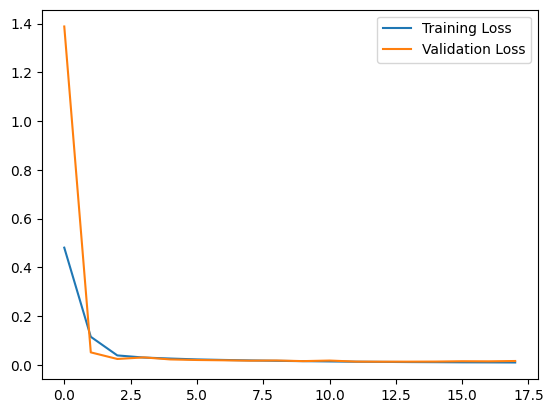

In [36]:

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Inferenz

Nun können Anomalien anhand der rekonstruierten Daten erkannt werden.

1.   Der mittlere absolute Fehler (Abweichung) der Vorhersagen wird ermittelt
2.   Der maximale mittelere absolute Fehler wird als Grenzwert `threshold` für die Anomalieerkennung festgelegt. Dabei wird noch ein Faktor zur Gewichtung angewandt, mit dem die Toleranz gegenüber Abweichungen angepasst werden kann.
3.   Wenn die Abweichung einer Rekonstruktion höher als die gewichtete `threshold` ist, wird der Punkt als Anomalie `anomaly` gekennzeichnet.

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


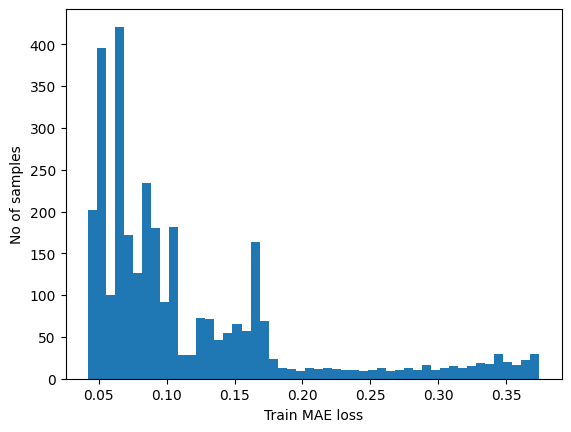

Reconstruction error threshold:  0.22450886188397992


In [37]:
threshold_factor = 0.6

# Get train MAE loss.
x_train_pred = model.predict(training_data)
train_mae_loss = np.mean(np.abs(x_train_pred - training_data), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)*threshold_factor
print("Reconstruction error threshold: ", threshold)


Hier wird die Rekonstruktion des Modells mit den ursprünglichen Daten für die erste Sequenz der Trainingsdaten verglichen.

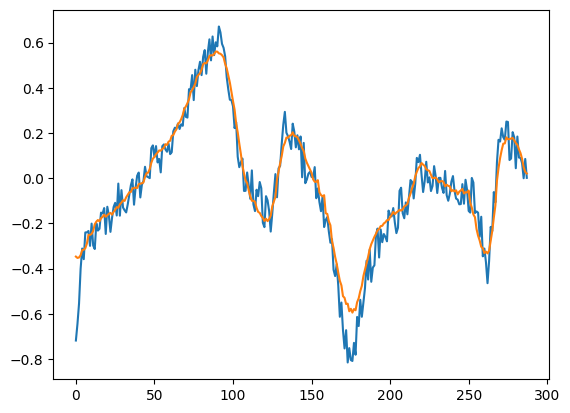

In [38]:
# Checking how the first sequence is learnt
plt.plot(training_data[0])
plt.plot(x_train_pred[0])
plt.show()

Der vollständige Datensatz wird für den Test normalisiert.

<Axes: xlabel='timestamp'>

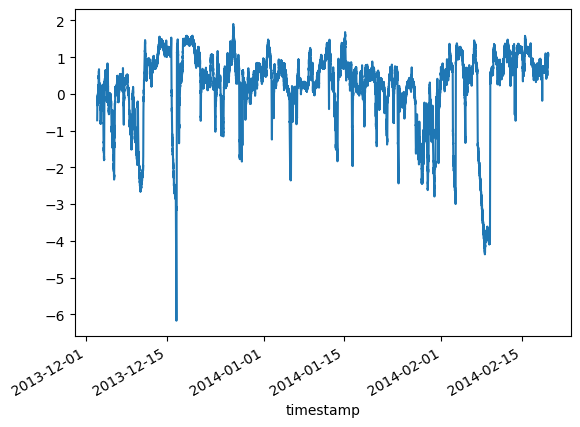

In [39]:
test_data = (temp_time_data - training_mean) / training_std
fig, ax = plt.subplots()
test_data.plot(legend=False, ax=ax)

In [40]:
# Sequenzen der Testdaten erstellen
x_test = create_sequences(test_data.values)
print("Test input shape: ", x_test.shape)

# Vorhersagen des Modells
x_test_pred = model.predict(x_test)

# Mittlerer absoluter Fehler (Abweichung) des Modells
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))



Test input shape:  (22408, 288, 1)
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


## Visualisierung der Anomalien

Wir können uns anschauen wie die Abweichungen verteilt waren.

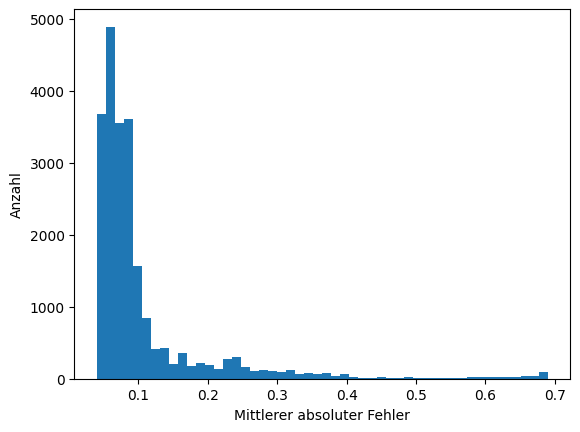

Gesamtzahl der Anomalien:  2135


In [41]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("Mittlerer absoluter Fehler")
plt.ylabel("Anzahl")
plt.show()

# Gesamtzahl an Anomalien
anomalies_sequences = test_mae_loss > threshold
print("Gesamtzahl der Anomalien: ", np.sum(anomalies_sequences))

Der Anomalie-Wert für die jeweilige Sequenz wird in den ursprünglichen Daten dem jeweils letzten Punkt der Sequenz zugeordnet. Für die ersten (TIME_STEPS - 1) Punkte liegt keine vollständige Sequenz vor und sie liegen ohnehin in den Trainingsdaten, deshalb werden diese als normal angenommen.

Um die steigende Signifikanz einer Anomalie zu ermitteln, werden die aufeinanderfolgenden Anomalie-Punkte gezählt und als Blöcke zusammengefasst.

In [42]:
# Übertragung der Anomalie-Werte von den Sequenzen auf die Datenpunkte
temp_time_data['anomaly'] = 1 # 1 = normal
temp_time_data.iloc[TIME_STEPS - 1:, temp_time_data.columns.get_loc('anomaly')] = np.where(anomalies_sequences, -1, 1)

# Identifizieren aufeinanderfolgender Anomalie-Punkte
is_anomaly = temp_time_data['anomaly'] == -1

# Zusammenfassung zu Anomalie-Blöcken
anomaly_blocks = (is_anomaly.diff() != 0).cumsum()

# Zählen der aufeinanderfolgenden Anomalie-Punkte
temp_time_data['consecutive_count'] = is_anomaly.groupby(anomaly_blocks).cumsum()

# DataFrame, der nur die Punkte enthält, die Teil eines Anomalie-Blocks sind
anomalies = temp_time_data[temp_time_data['consecutive_count'] > 0]

Jetzt sollen die Daten als Overlay über die ursprünglichen Daten gelegt werden. Aufeinanderfolgende Anomalie-Punkte werden mit einer Farbskala markiert, um steigende Signifikanz zu verdeutlichen.

/tmp/ipykernel_16959/2957613591.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('plasma')


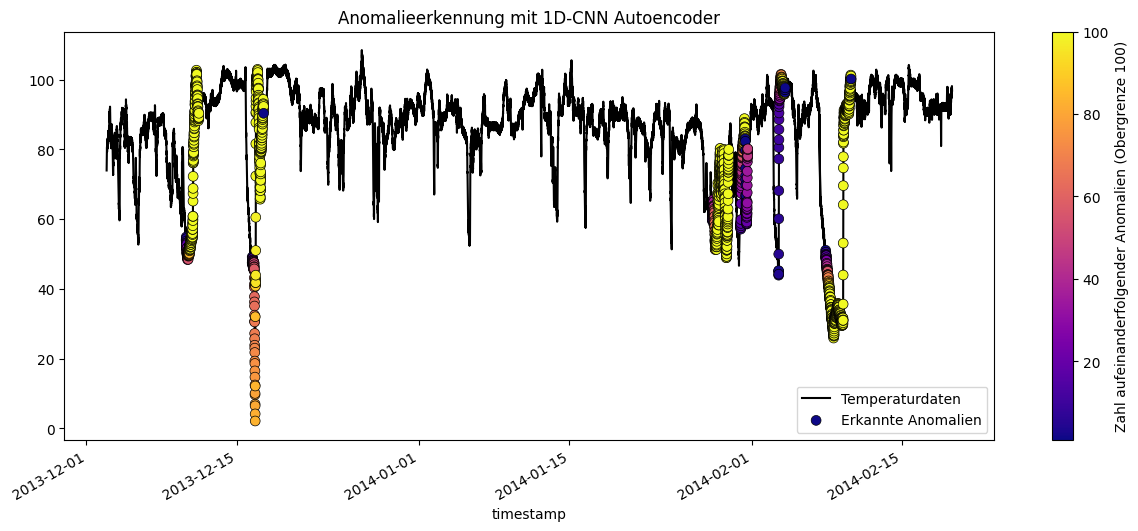

In [43]:
# Oberes Limit für Farbskala als maximale Signifikanz
COLORBAR_UPPER_LIMIT = 100

# Farbskala
cmap = plt.cm.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(15, 6))
temp_time_data['value'].plot(legend=False, ax=ax, label='Temperaturdaten', color='black', zorder=1)

scatter = ax.scatter(
    anomalies.index, 
    anomalies['value'],
    c=anomalies['consecutive_count'], 
    cmap=cmap, 
    vmin=1, # Start der Farbskala
    vmax=COLORBAR_UPPER_LIMIT, # Obergrenze der Farbskala
    s=50,
    edgecolors='k',
    linewidths=0.5,
    label='Erkannte Anomalien',
    zorder=2
)

plt.legend()
plt.title('Anomalieerkennung mit 1D-CNN Autoencoder')
cbar = fig.colorbar(scatter)
cbar.set_label(f'Zahl aufeinanderfolgender Anomalien (Obergrenze {COLORBAR_UPPER_LIMIT})')
plt.show()

## Vergleich mit Referenzmodell und Wahrheitswerten

Zunächst laden wir die Daten von [einem der Ergbnis-Datensätze](https://github.com/numenta/NAB/blob/master/results/ARTime/realKnownCause/ARTime_machine_temperature_system_failure.csv) des NAB-Benchmarks und übernehmen daraus die Ground Truth-Werte. Die Werte sind binär, wobei 1 für eine Anomalie steht und 0 für einen normalen Punkt.

In [44]:
truth_file_path = "datasets/univariate_machine_temp/ARTime_machine_temperature_system_failure.csv" 

df_truth = pd.read_csv(truth_file_path, parse_dates=True, index_col="timestamp")

# Die Ground Truth Werte aus der Spalte label werden in den ursprünglichen Datensatz aufgenommen
temp_time_data.sort_index(inplace=True)
df_truth.sort_index(inplace=True)
df_combined = temp_time_data.join(df_truth[['label']])

# Möglicherweise fehlende Label werden mit 0 aufgefüllt (für "normal")
df_combined['label'].fillna(0, inplace=True)

/tmp/ipykernel_16959/2347506276.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['label'].fillna(0, inplace=True)


Hier nutzen wir das Metrics Feature von Scikit-Learn, um die Genauigkeit der Klassifizierung zu bewerten.

In [45]:
from sklearn.metrics import classification_report

# Ersten (TIME_STEPS - 1) Sequenzen werden von Vorhersagen und Ground Truth ausgenommen für den Vergleich
y_pred = df_combined['anomaly'].iloc[TIME_STEPS - 1:].values
y_true_original = df_combined['label'].iloc[TIME_STEPS - 1:].values

# Ground Truth-Label werden angepasst an die Ausgabe des Modells (-1, 1)
y_true = np.where(y_true_original == 1, -1, 1)

# Erzeugt einen Bericht zu Precision, recall und f1-score.
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Anomalie (-1)', 'Normal (1)']))


--- Classification Report ---
               precision    recall  f1-score   support

Anomalie (-1)       0.71      0.67      0.69      2268
   Normal (1)       0.96      0.97      0.97     20164

     accuracy                           0.94     22432
    macro avg       0.84      0.82      0.83     22432
 weighted avg       0.94      0.94      0.94     22432



Jetzt ergänzen wir den vorherigen Graph mit der Farbskala noch um eine Markierung der Ground Truth-Werte.

/tmp/ipykernel_16959/2804150962.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  starts = df_combined.index[is_true_anomaly & ~is_true_anomaly.shift(1).fillna(False)]
/tmp/ipykernel_16959/2804150962.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ends = df_combined.index[is_true_anomaly & ~is_true_anomaly.shift(-1).fillna(False)]


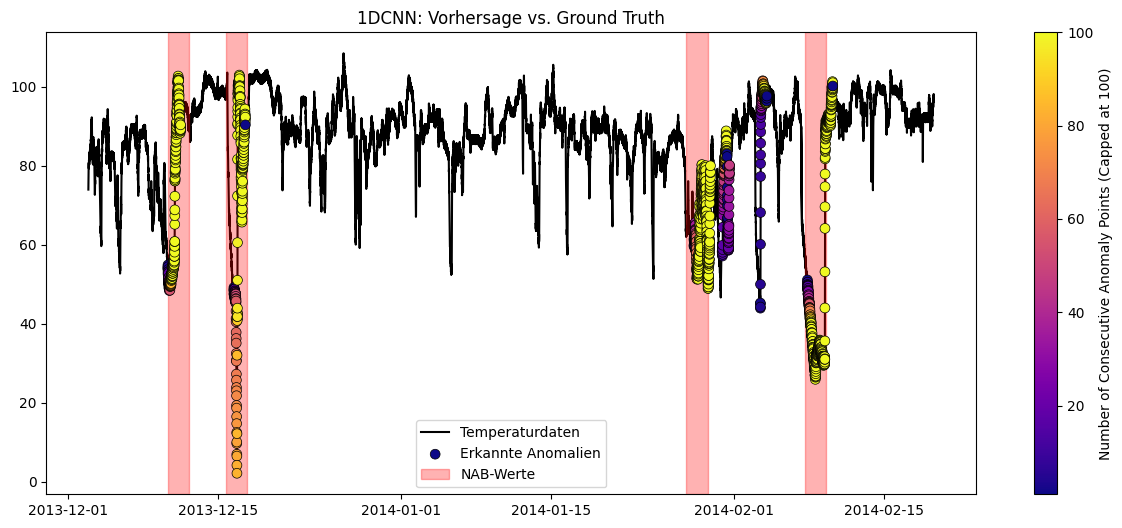

In [46]:
# Start und Ende der Anomalien werden aus den Label-Daten ermittelt
is_true_anomaly = df_combined['label'] == 1
starts = df_combined.index[is_true_anomaly & ~is_true_anomaly.shift(1).fillna(False)]
ends = df_combined.index[is_true_anomaly & ~is_true_anomaly.shift(-1).fillna(False)]

# Ursprünglicher Plot
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_combined.index, df_combined['value'], label='Temperaturdaten', color='black', zorder=1)

predicted_anomalies = df_combined[df_combined['consecutive_count'] > 0]

scatter = ax.scatter(
    predicted_anomalies.index, 
    predicted_anomalies['value'], 
    c=predicted_anomalies['consecutive_count'], 
    cmap=cmap, 
    vmin=1,
    vmax=COLORBAR_UPPER_LIMIT,
    s=50,
    edgecolors='k',
    linewidths=0.5,
    label='Erkannte Anomalien',
    zorder=3
)

# Tatsächliche Anomalie-Abschnitte werden farblich markiert
if not starts.empty and not ends.empty:
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, color='red', alpha=0.3, label='_nolegend_')
ax.fill_between([], [], color='red', alpha=0.3, label='NAB-Werte')


ax.legend()
ax.set_title('1DCNN: Vorhersage vs. Ground Truth')
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label(f'Number of Consecutive Anomaly Points (Capped at {COLORBAR_UPPER_LIMIT})')
plt.show()


Aus der wissenschaftlichen Veröffentlichung zum NAB: 
"The first anomaly was a planned shutdown. The third anomaly is a catastrophic system failure. The second anomaly, a subtle but observable change in the behavior, indicated the actual onset of the problem that led to the eventual system failure."

<img src="ground_truth.png" alt="Alt text" width="800">

